# Turing version


Goal is to make this match the sunode version and test.  Much of this is cribbed from: https://turinglang.org/v0.30/tutorials/10-bayesian-differential-equations/

As in the sunode version, we will use both pred and prey observations

In [1]:
using Turing
using DifferentialEquations

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

using LinearAlgebra

# Set a seed for reproducibility.
using Random
Random.seed!(14);

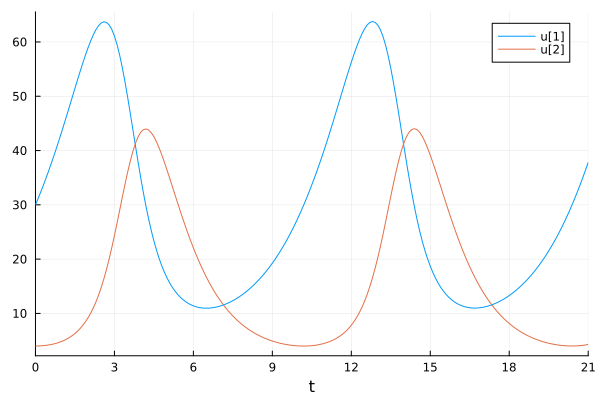

In [2]:
# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end

# Define initial-value problem. This is the "truth" we will try to recover
u0 = [30.0, 4.0]
p = [.5,.03,.9,.03]
tspan = (0.0, 21.0)  # 21 years 
prob = ODEProblem(lotka_volterra, u0, tspan, p)
sol = solve(prob, Tsit5(), saveat=0.1)
# Plot simulation.
plot(sol)

Sample at each 'year'.  u[1] is our prey (hares) and u[2] is our predator (lynx)

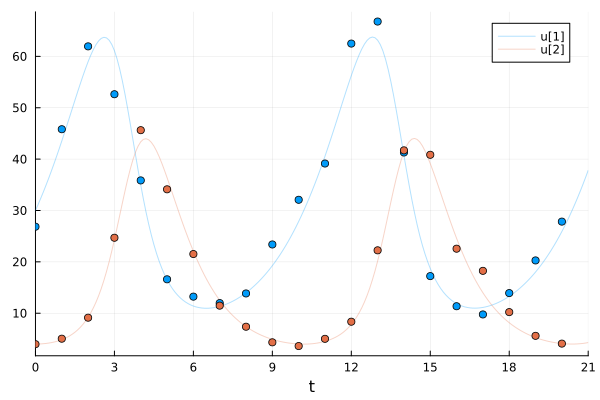

In [24]:
times = collect(range(0, 20))
sol_measure = solve(prob,  TRBDF2(), saveat = times)
# add noise
odedata = exp.(log.(Array(sol_measure)) + 0.1 * randn(size(Array(sol_measure))))
# Plot simulation and noisy observations.
plot(sol; alpha=0.3)
scatter!(times, odedata'; color=[1 2], label="")

### Export odedata for use in sunode version:

In [64]:
# export odedata : 
# using DataFrames, CSV
# df = DataFrame(hare = odedata[1,:], lynx = odedata[2,:], times = times)
# CSV.write("ode_data.csv", df)

"ode_data.csv"

For future runs, read in the data:

In [9]:
using DataFrames, CSV
df = CSV.read("ode_data.csv", DataFrame)
odedata = [df.hare'; df.lynx']
times = df.times;

In [10]:
@model function fitlv(data, prob)
    # Prior distributions.
    x0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
    y0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
     
    # Compute the parameters of the ode based on our prior parameters
    α ~ truncated(Normal(.5, 1); lower=0, upper=2)
    β ~ truncated(Normal(.5, 1); lower=0, upper=2)
    γ ~ truncated(Normal(.5, 1); lower=0, upper=2)
    δ ~ truncated(Normal(.5, 1); lower=0, upper=2)
    σ ~ Exponential(1)
 

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    u0 = [x0, y0]
    predicted = solve(prob,  TRBDF2(); u0=u0, p=p, saveat=times)
    
    # Observations with multiplicative noise.
    for i in 1:length(predicted)
        # hacky but it works
        log_pred = log.(max.(predicted[i],0))
        data[:, i] ~ MvLogNormal(log_pred, σ^2 * I)
    end

    return nothing
end

fitlv (generic function with 2 methods)

TODO:   Figure out how to keep it from erroring . With the un-reparammeterized version, it is fine and fast.  So perhaps redo sunode that way too and screw it.

In [11]:

model = fitlv(odedata, prob)


DynamicPPL.Model{typeof(fitlv), (:data, :prob), (), (), Tuple{Matrix{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lotka_volterra), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}}, Tuple{}, DynamicPPL.DefaultContext}(fitlv, (data = [26.840329406112943 45.8181186884277 … 20.27765285539816 27.83309023749979; 3.97091833534422 5.039586294251105 … 5.596935760570745 4.083163401832275], prob = ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lotka_volterra), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, No

In [12]:

# Sample 4 independent chains with forward-mode automatic differentiation (the default).
chain = sample(model, NUTS(), MCMCSerial(), 1000, 4,progress=false)

┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191


┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191


Chains MCMC chain (1000×19×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 114.43 seconds
Compute duration  = 112.44 seconds
parameters        = x0, y0, α, β, γ, δ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

          x0   31.3625    1.0901    0.0218   2530.7181   2370.3983    1.0009   ⋯
          y0    4.0823    0.1439    0.0029   2520.3934   2177.3700    1.0009   ⋯
           α    0.4997    0.0217    0.0006   1336.8634   1745.9189    1.0025   ⋯
           β    0.0293    0.0017    0.0000   1400.4525   1742.0342    1.0025   ⋯
           γ    0.9016    0.0376    0.0010   1281

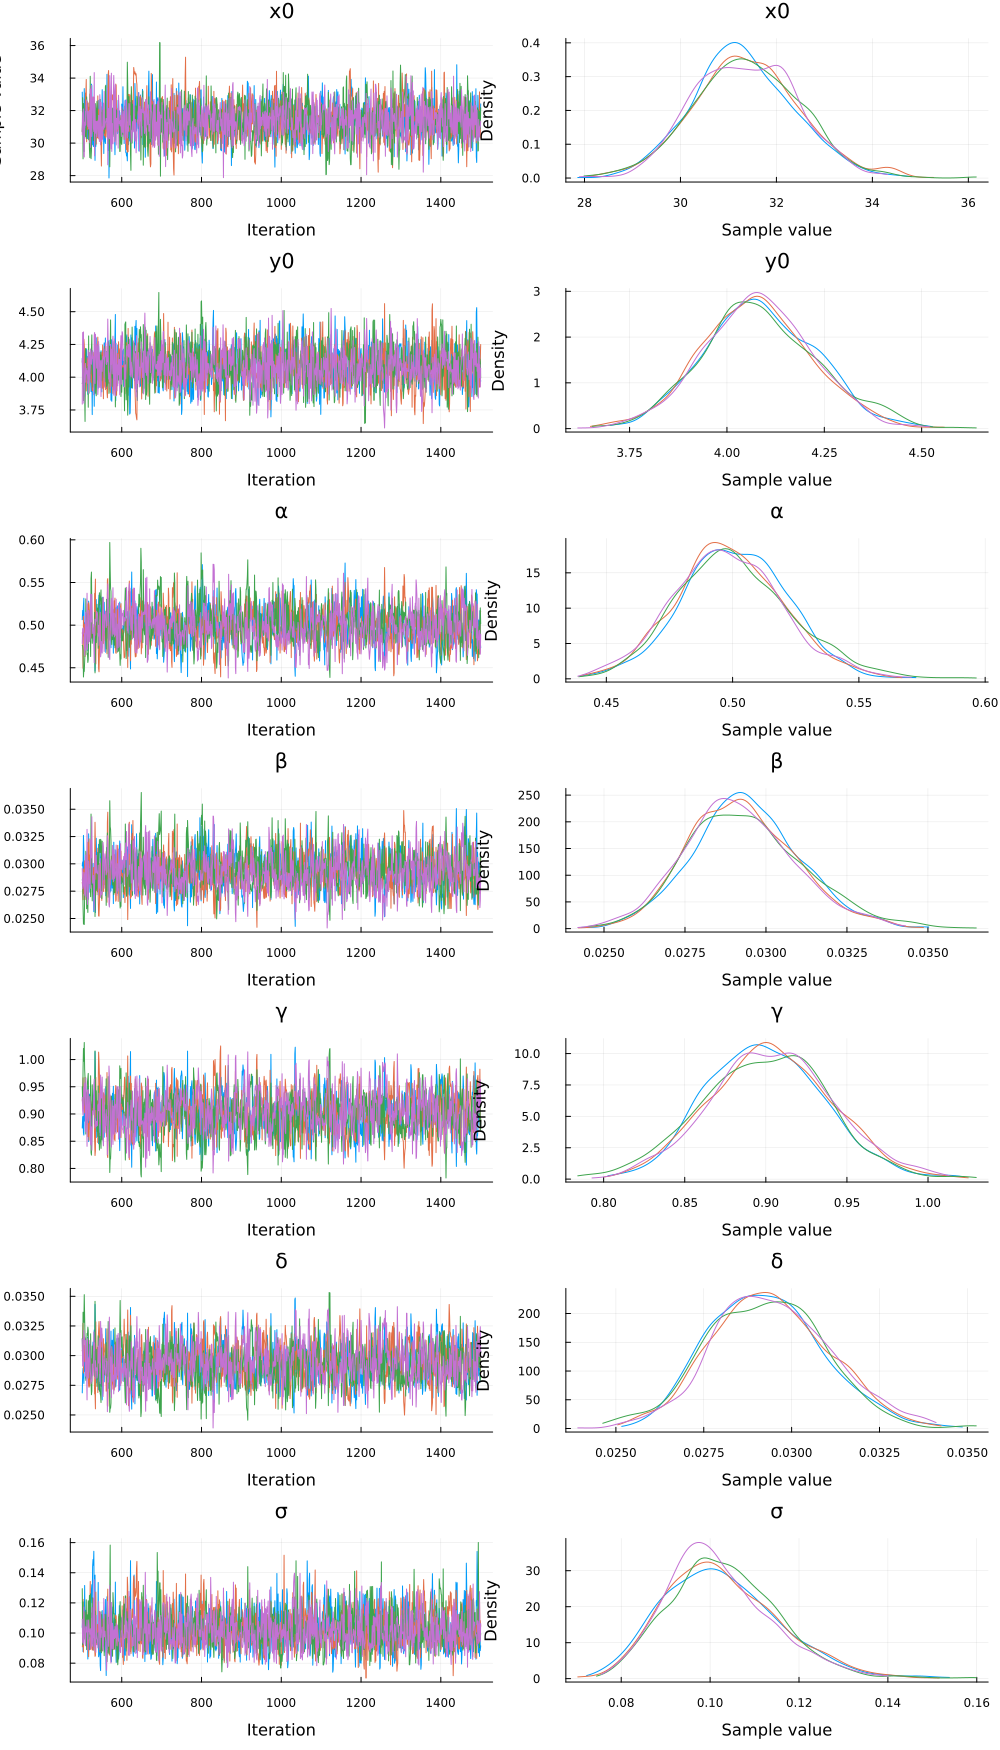

In [13]:
plot(chain)

In [59]:
posterior_samples = sample(chain[[:x0,:y0,:α, :β, :γ, :δ]], 300; replace=false);

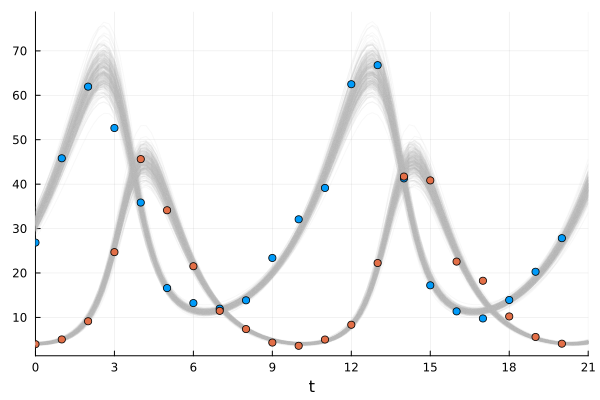

In [60]:
plot(; legend=false)
posterior_samples = sample(chain[[:x0,:y0,:α, :β, :γ, :δ]], 300; replace=false)
for row in eachrow(Array(posterior_samples))
    u0 = row[1:2]
    p = row[3:end]
    sol_p = solve(prob, Tsit5();u0=u0, p=p, saveat=0.2)
    plot!(sol_p; alpha=0.1, color="#BBBBBB")
end

# Plot simulation and noisy observations.
#plot!(sol; color=[1 2], linewidth=1)
scatter!(times, odedata'; color=[1 2])